In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import onnxruntime as rt
from tqdm import tqdm

In [6]:
# constants and parameters definition
data_path = '../data/300k_dataset.csv'
good_model_path = '../model/good_model.onnx'
biased_model_path = '../model/biased_model.onnx'

In [29]:
# calculations
def calculate_distribution(preds):
    return np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)

def differential_testing_by_sensitive_variable(
        model1_path,
        model2_path,
        data_address,
        sensitive_attributes
):
    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
    X = X.astype(np.float32)

    session1 = rt.InferenceSession(model1_path)
    session2 = rt.InferenceSession(model2_path)
    input_name1 = session1.get_inputs()[0].name
    input_name2 = session2.get_inputs()[0].name

    results = {}

    for attr in tqdm(sensitive_attributes):
        print(f"Analyzing bias for sensitive attribute: {attr}")
        attr_values = data[attr].unique()
        heatmap_data = []

        for value in tqdm(attr_values, desc=f"Processing {attr}", leave=True):
            mask_value = (data[attr] == value)
            sub_X_value = X[mask_value]

            mask_others = (data[attr] != value)
            sub_X_others = X[mask_others]

            preds_model1_value = session1.run(None, {input_name1: sub_X_value.values.astype(np.float32)})[0]
            preds_model2_value = session2.run(None, {input_name2: sub_X_value.values.astype(np.float32)})[0]

            preds_model1_others = session1.run(None, {input_name1: sub_X_others.values.astype(np.float32)})[0]
            preds_model2_others = session2.run(None, {input_name2: sub_X_others.values.astype(np.float32)})[0]

            if preds_model1_value.ndim > 1:
                preds_model1_value = np.argmax(preds_model1_value, axis=1)
                preds_model2_value = np.argmax(preds_model2_value, axis=1)
                preds_model1_others = np.argmax(preds_model1_others, axis=1)
                preds_model2_others = np.argmax(preds_model2_others, axis=1)

            dist_model1_value = calculate_distribution(preds_model1_value)
            dist_model2_value = calculate_distribution(preds_model2_value)

            dist_model1_others = calculate_distribution(preds_model1_others)
            dist_model2_others = calculate_distribution(preds_model2_others)

            kl1 = entropy(dist_model1_value, qk=dist_model1_others)
            kl2 = entropy(dist_model2_value, qk=dist_model2_others)

            heatmap_data.append([value, kl1 - kl2])

        results[attr] = heatmap_data

    return results

def visualize_kl_divergences_heatmap(results):
    for attr, kl_data in results.items():
        heatmap_df = pd.DataFrame(kl_data, columns=[f'{attr} Value', 'KL Difference'])
        heatmap_df = heatmap_df.set_index(f'{attr} Value').T
        plt.figure(figsize=(30, 6))
        sns.heatmap(
            heatmap_df,
            annot=True,
            fmt=".4f", 
            cmap='coolwarm',
            center=0,
            annot_kws={"size": 10} 
        )
        plt.title(f'Heatmap of KL Divergence Difference for {attr}', fontsize=16)  
        plt.xticks(fontsize=12, rotation=45) 
        plt.yticks(fontsize=10)
        plt.xlabel(f'{attr} Values', fontsize=14)
        #plt.ylabel('KL Difference', fontsize=12)
        plt.tight_layout()  
        plt.show()



In [24]:
# test

results = differential_testing_by_sensitive_variable(
    good_model_path,
    biased_model_path,
    data_path,
    sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_spreektaal']
)

  0%|          | 0/3 [00:00<?, ?it/s]

Analyzing bias for sensitive attribute: persoon_leeftijd_bij_onderzoek



 33%|███▎      | 1/3 [02:54<05:48, 174.43s/it]

Analyzing bias for sensitive attribute: persoon_geslacht_vrouw



 67%|██████▋   | 2/3 [02:58<01:14, 74.33s/it] 

Analyzing bias for sensitive attribute: persoonlijke_eigenschappen_spreektaal



Processing persoonlijke_eigenschappen_spreektaal:   0%|          | 0/18 [00:00<?, ?it/s]
Processing persoonlijke_eigenschappen_spreektaal:   6%|▌         | 1/18 [00:02<00:34,  2.05s/it]
Processing persoonlijke_eigenschappen_spreektaal:  11%|█         | 2/18 [00:04<00:32,  2.06s/it]
Processing persoonlijke_eigenschappen_spreektaal:  17%|█▋        | 3/18 [00:06<00:30,  2.05s/it]
Processing persoonlijke_eigenschappen_spreektaal:  22%|██▏       | 4/18 [00:08<00:28,  2.00s/it]
Processing persoonlijke_eigenschappen_spreektaal:  28%|██▊       | 5/18 [00:10<00:26,  2.05s/it]
Processing persoonlijke_eigenschappen_spreektaal:  33%|███▎      | 6/18 [00:12<00:24,  2.08s/it]
Processing persoonlijke_eigenschappen_spreektaal:  39%|███▉      | 7/18 [00:14<00:23,  2.12s/it]
Processing persoonlijke_eigenschappen_spreektaal:  44%|████▍     | 8/18 [00:16<00:21,  2.14s/it]
Processing persoonlijke_eigenschappen_spreektaal:  50%|█████     | 9/18 [00:19<00:19,  2.18s/it]
Processing persoonlijke_eigenschappen

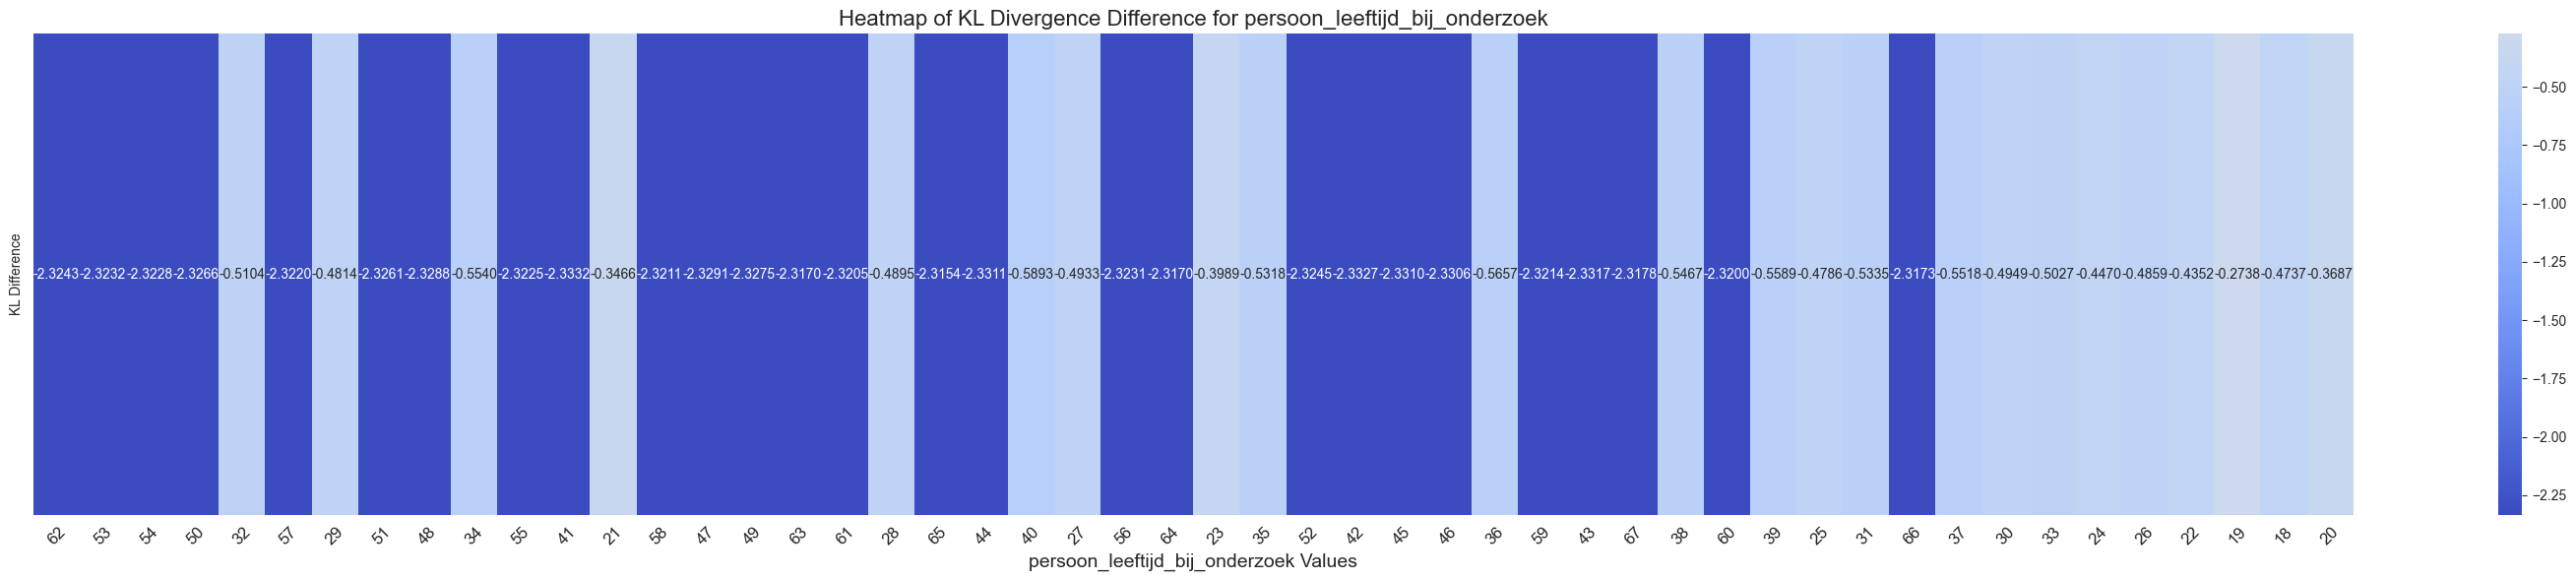

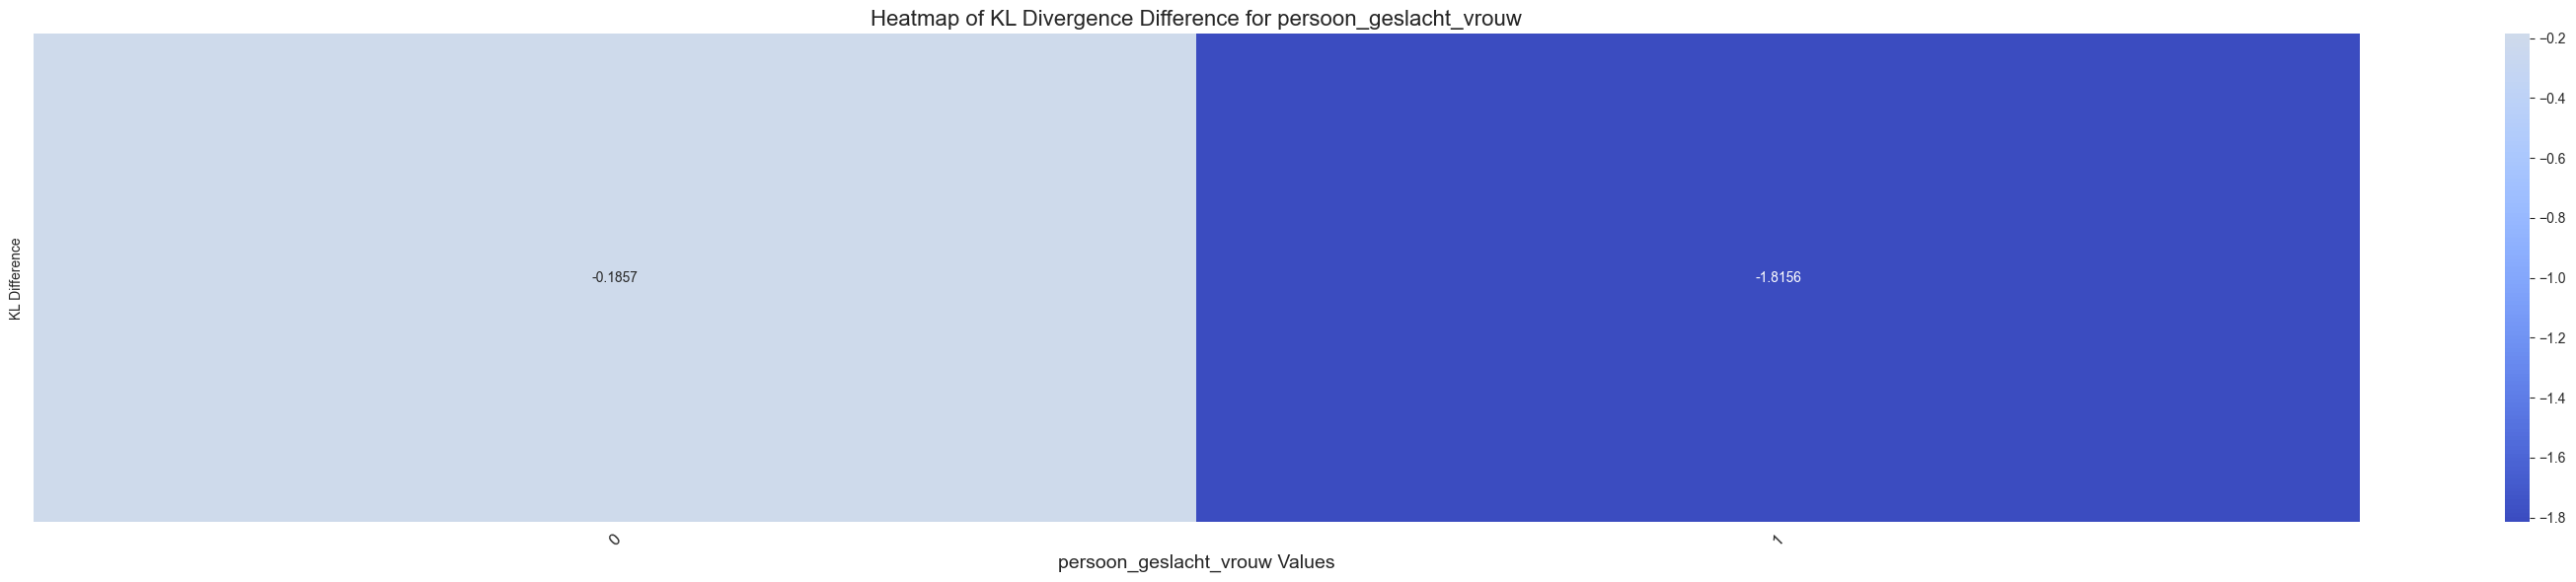

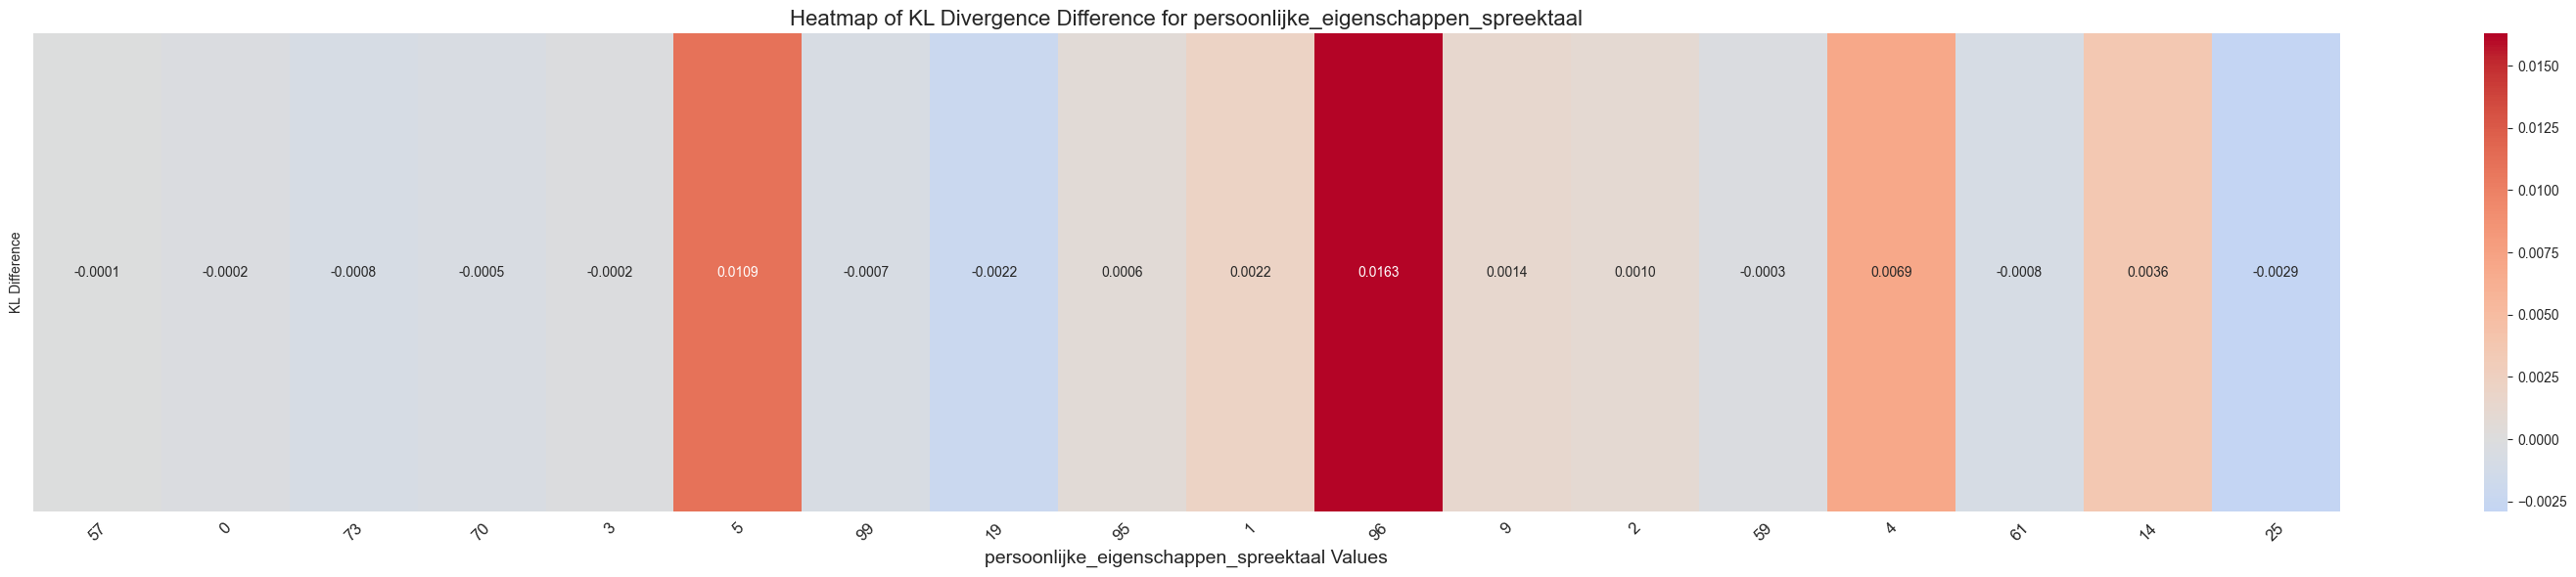

In [30]:
# visualize results

visualize_kl_divergences_heatmap(results)
